In [19]:
import numpy as np
import pickle
import os
from collections import defaultdict as ddict
import gzip

import stationary_distribution_aug as sd
import mutator_classes

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

In [20]:
sns.set_style('whitegrid')
mpl.rcParams['figure.dpi'] = 400
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['legend.title_fontsize'] = 10

In [21]:
in_path = '/Users/will_milligan/PycharmProjects/MUTATOR_FINAL/mean_frequency'

In [22]:
# load and process simulated data
def load_data(in_path):
    
    data = {}
    # walk input directory for results for different S values
    for param_dir in os.listdir(in_path):
        
        param_dir_full = os.path.join(in_path,param_dir)
        if os.path.isdir(param_dir_full):
            
            S = 10**(eval(param_dir.split('_S')[-1]))
            data[S] = {}
            # walk S directory for results for different replicates
            for v_dir in os.listdir(param_dir_full):
                V = eval(v_dir.replace('V',''))
                
                # load the corresponding data
                with gzip.open(os.path.join(os.path.join(param_dir_full,v_dir),'summarized_mean_freqs.pickle.gz'),'rb') as fin:
                    
                    # {pop: mean frequency for each modifier site}
                    mean_freq_dict = pickle.load(fin)
                    
                data[S][V] = mean_freq_dict
            
    return process_data(data)


def process_data(data):
    
    summarized_data = {}
    for S, Sdict in data.items():
        summarized_data[S] = {}
        
        # consolidate data from all replicates
        all_values = ddict(list)
        for V,Vdict in Sdict.items():
            for pop, pop_list in Vdict.items():
                all_values[pop].extend(pop_list)
        
        # calculate the summary statistics for each population
        for pop,pop_values in all_values.items():
            summarized_data[S][pop] = (np.mean(pop_values),np.std(pop_values),len(pop_values))

    return summarized_data

data = load_data(in_path)

In [23]:
# calculate stationary distributions
def get_phi(S,p):
    return S/(p.h*p.s*p.loci*p.N*4)

population = mutator_classes.Parameters(**{'mutation_rate':1,'h':1,'s':0.0005,'mutator_mutation_rate':1.25e-8,'M':1,'phi':1,'N':20000,'loci':3e9/32*0.08})

# generate stationary distributions for different values of phi
analytic_results = {}
for i,S in enumerate(np.logspace(-2,3,51)):
    phi = get_phi(S,population)
    statdist = sd.get_SD(p=population,phi = phi)
    analytic_results[S] = statdist, phi

In [17]:
# calculate analytic results from simulations
def process_analytic_results(results):
    
    processed_results = {}
    
    # calculate the mean mutation rate increase for each value of phi
    for S,(statdist,phi) in results.items():
        mean = sum(p*q for p,q in statdist.items())*2*phi
        processed_results[S] = mean
    return processed_results

processed_analytic_results = process_analytic_results(analytic_results)

In [25]:
# plotting instructions
def mean_plot(ax,sim_data,analytic_data,p):
    
    # plot analytic results
    ax.plot(list(analytic_data.keys()),list(analytic_data.values()),color='grey',ls='-',marker='None',zorder=1,label='Analytic approx.')
    
    for S,pop_dict in sim_data.items():
        
        average_mean = 0
        average_std = 0
        
        phi = get_phi(S,p)
        
        # calculate weighted average of frequency
        for pop,(mean,std,n) in pop_dict.items():
            if pop == 'CEU':
                color = 'r'
                weight = 1/8
            elif pop == 'YRI': 
                color = 'b'
                weight = 1/8
            else:
                color = 'k'
                weight = 6/8
            
            average_mean += mean*weight*2*phi
            average_std += std*weight/n**(0.5)*2*phi
            
        # plot simualted results, but only one label
        if np.isclose(S,1e-2,rtol=0.01):
            ax.errorbar(S,average_mean,2*average_std,color='k',ls='None',marker='.',alpha=1,label='Simulated mean \n' + r'$\pm$ 2 SEs')
        else:
            ax.errorbar(S,average_mean,2*average_std,color='k',ls='None',marker='.',alpha=1)
    
    ax.set_yscale('log')
    ax.set_xscale('log')

1.0


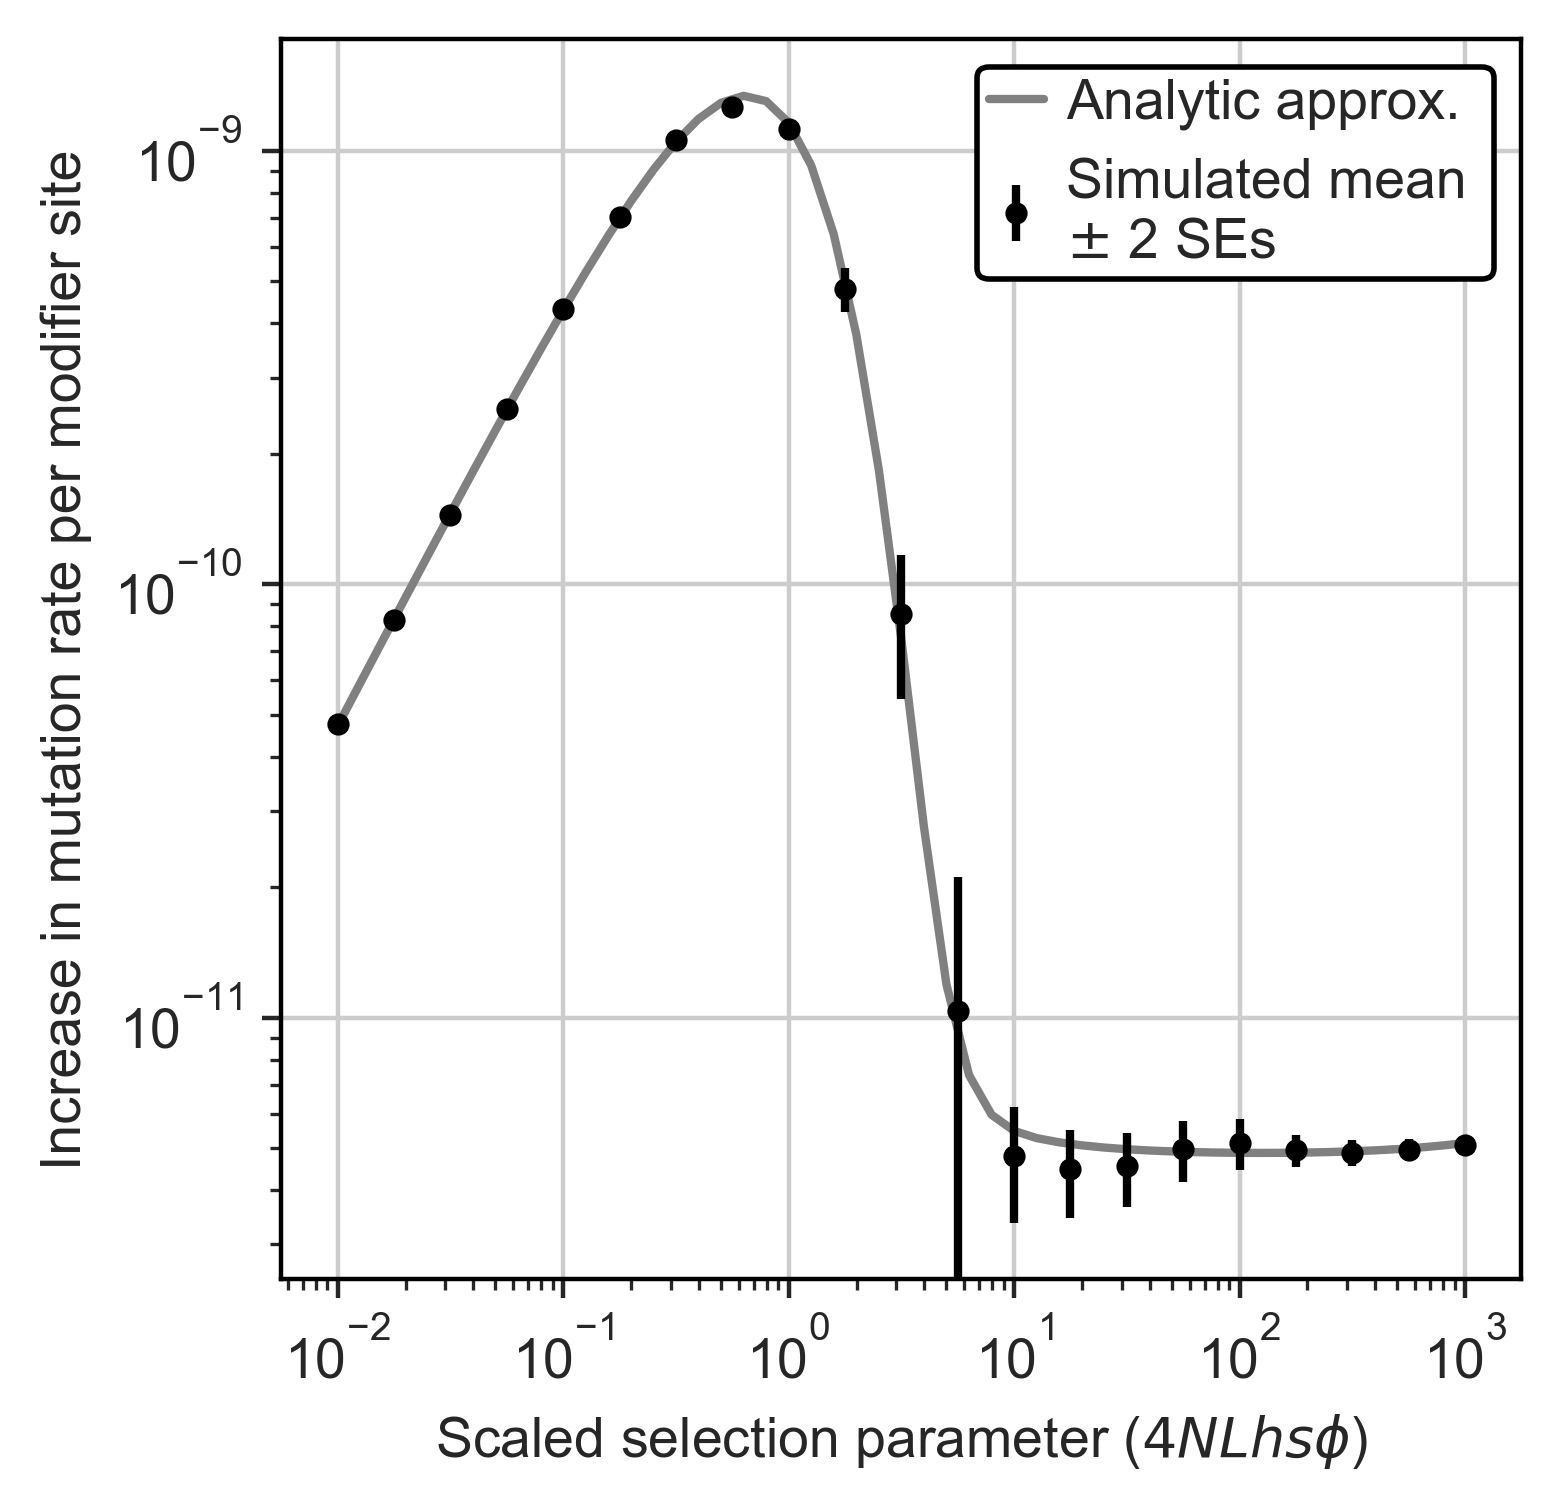

In [26]:
fig = plt.figure(figsize=(4,4.105),dpi=400)
ax = plt.gca()
mean_plot(ax=ax,sim_data = data, analytic_data=processed_analytic_results, p = population)

# make graphs nice
ax.tick_params(bottom=True,left=True,labelbottom=True,labelleft=True,which='both')
for spine in ax.spines.values():
    spine.set_color('k')
ax.set_xlabel(r'Scaled selection parameter ($4NLhs\phi$)')
ax.set_ylabel(r'Increase in mutation rate per modifier site')
ax.legend(framealpha = 1, edgecolor='k',
          loc='upper right',
          handlelength = 1,
               handletextpad = 0.4,
               borderaxespad = 0.5,
               borderpad = 0.2,)
plt.subplots_adjust(wspace=0.3)
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height
print(round(width/height,3))